## $$ \text{TP5 - Fractional Step/Pressure Projection Method - Stoke’s Equation - MU4MEM02} $$

$$\textit{DUVIVIER Valentin} - CompMech$$

$ $

$ $

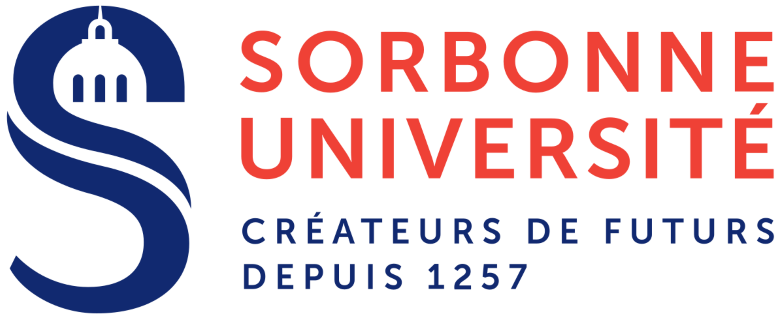

$ $

$ $

# Code for resolution of the Stoke's equation

#### Libraries

In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import os, sys
sys.path.append('src')
from Poisson_solve import *
from utility import *
from Diff_solve import *

#### Setting the grid parameters and flow conditions

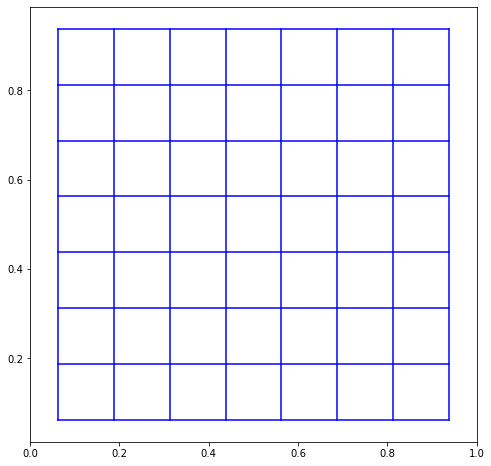

In [2]:
## Mesh

# Space
n     = 3
m     = n

N     = 2**n+2       # resolution (should be 2^n + 2)
M     = 2**m+2       # grid aspect ratio of 1

# Time
tstep = 10           # number of time-steps 
dt    = 0.025        # this is actually dt/Re 

# resulting vectors
dx    = 1/(N-2)
dy    = 1/(M-2)

x     = np.linspace(dx/2, 1-dx/2, num = N-2)
y     = np.linspace(dy/2, 1-dy/2, num = M-2)

# ----------------------------------------

# Display
plt.figure(figsize=(8,8))

X, Y = np.meshgrid(x, y)

plt.plot(  X,   Y, 'b-')
plt.plot(X.T, Y.T, 'b-')

plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

#### Initial condition

In [3]:
u = np.zeros((N, M))  # initial flow fields
v = np.zeros((N, M))
p = np.zeros((N, M))  # initial pressure fields

#### Iterative Scheme

In [4]:
uold  = np.zeros((N, M))
vold  = np.zeros((N, M))
ustar = np.zeros((N, M))
vstar = np.zeros((N, M))
d     = np.zeros((N, M))
pnew  = np.zeros((N, M))

uold  = u            # initialization of iterative scheme 
vold  = v

# begin time loop 
for i in range(1, tstep + 1):
    print('time step', i)

    # begin iterative loop 
    for k in range (1, 6): #11
        print('      iteration step', k)
        
        # implicit time-step for u
        ustar = DiffU(uold, p, dt, n)
        
        # implicit time-step for v 
        vstar = DiffV(vold, p, dt, n)

        # compute divergence
        d = diverg(ustar, vstar, dt)
        
        # solve pressure Poisson equation
        pnew = Poiss(p, d)
        
        # correct the velocity fields
        u = ucorr(ustar, pnew, dt)
        v = vcorr(vstar, pnew, dt)
        
        # update pressure
        p = pnew

    # accept velocity fields (after 10 iterations) 
    uold = u 
    vold = v

time step 1
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 2
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 3
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 4
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 5
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 6
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 7
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      iteration step 5
time step 8
      iteration step 1
      iteration step 2
      iteration step 3
      iteration step 4
      i

(0.0, 1.0)

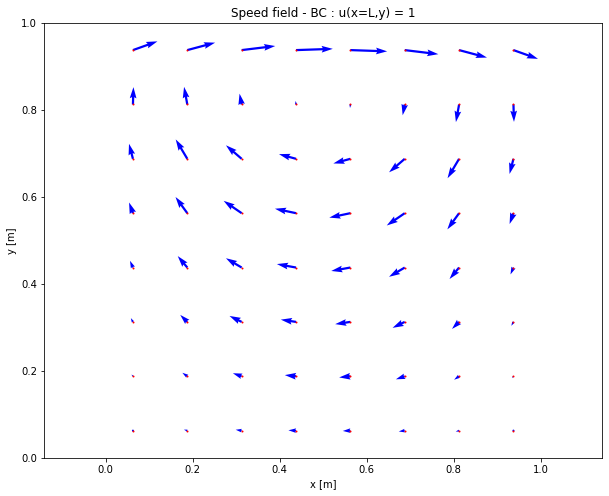

In [5]:
## Graph

plt.figure(figsize=(10,8))

plt.quiver(Y, X, u[1:-1,1:-1], v[1:-1,1:-1], scale=1 / 0.15, width=0.004, color='blue')
plt.scatter(X, Y, color='r', s=1)

plt.title(f'Speed field - BC : u(x=L,y) = 1')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)

# -------------------------------

#plt.savefig('Figures/speedField1.png')

TP4 : colocation
TP5 : cell centered method -> difference on the points we use to do average in multigrid method.

We must look at weight (bounded to distance) and nb of cells from coarse to fine and inversly fro multigrid methods.
This will help answering Q2.

If doing (f1 + f2 + f3 + f4)/4 -> imply same distance between points and do average. Yet during TP4, what was interpolated wasn't at center of grid -> different in the method.

### Repsonses

#### Q1 - Solving steps

In order to solve Stokes equations, we are to implement a split method known as multigrids method.

Here is the system we are to solve numerically :

$\partial_t u = \nabla p + \Delta u$ $\hspace{0.5cm} \leftrightarrow \hspace{0.5cm}$ Stokes equation

$\nabla.u = 0$ $\hspace{0.5cm} \leftrightarrow \hspace{0.5cm}$ incompressibility of the flow

$u(0\leq x\leq 1, 0\leq y\leq 1, t=0) = 0$ $\hspace{0.5cm} \leftrightarrow \hspace{0.5cm}$ Initial function

$u = g$ on $\partial \Omega, \forall t>0$ $\hspace{0.5cm} \leftrightarrow \hspace{0.5cm}$ BC on edge

 with $\underline{g} = \underline{ex}$ in $y=1$ for the moment. This recalls having a rightwards speed in $y=1$.

It consists into a simplification of Navier-Stokes equations as we don't take the convection into account, where we consider a 2D mesh, with 1 or two BC.
The purpose will be to do an iterative solving of this set of equations, and thanks to the right splitting method, to get the resulting speed field.

Here below are the steps one must go through for solving.

i.   $\frac{u^* - u^n}{\Delta t} = \Delta u^*$

ii.  $u^* = g +\Delta t \nabla p^{n+1}$ on $\partial \Omega$

iii. $\Delta p^{n+1} = \frac{\nabla u^*}{\Delta t}$

iv.  $\partial_n p^{n+1} = 0$

v.   $\frac{u^{n+1} - u^*}{\Delta t} = -\nabla p^{n+1}$

$\underline{\text{In details}}$ : 
    
i. The first step accounts for advancing the velocity field. We then solve a diffusion equation in a first step to discretize the time derivative.

ii. Then, we adapt our BC that was on g only at first. We thus include pressure field under discretized derivative term, as we avoided it in first step.

iii. At third, we determine the divergence field d in order to implement it into solving Poisson equation. 

iv. After we take into account neumann BC (continuity pressure field), we get the pressure field.

v. We finish resolution by a corrective part to get new iteration of u.

One then goes through this step a few times, which is what complete the iterative scheme.

Here below is the graph showing motion of particles in a 1 by 1 mesh, considering bouncing conditions on every edges except in $x = 1$ where we impose $u_x = 1$, i.e. a flow rightwards in $x = 1$ :

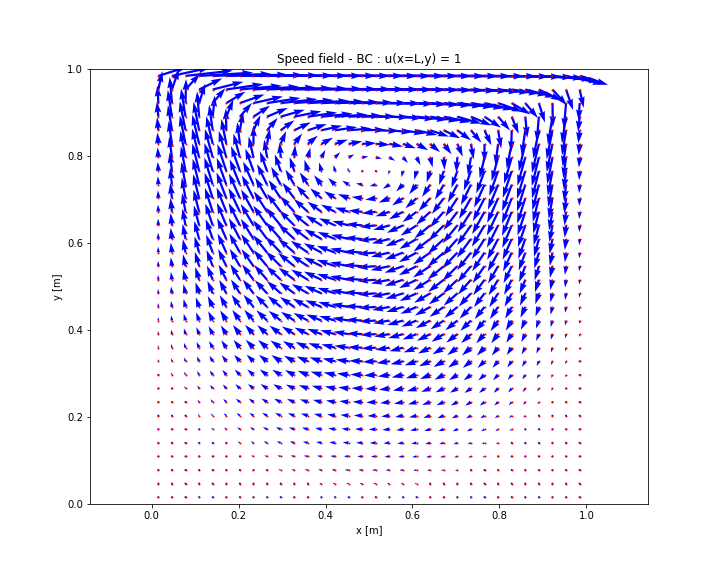

In [6]:
from IPython.display import display, Image, Math
i=Image(filename='Figures/speedField1.png', width=600)
display(i)

As we recall it, our initial speed field is zero. It implies that to get to the above graph, the flow has been put in motion due to BC on upper side, that as subsequently driven the flow into a circular motion. It has indeed been made possible thanks to bouncing BC on other edges and fields.

$\Rightarrow$ **As a conclusion on solving Stokes' equations, using the multigrid method we have reached a consistent velocity field that is in accordance with discussed fluid and mesh's properties. The scheme thus solved numerically fluid complex equation through simple steps, due to a splitting method. We'll see and discuss in the last part of this report different graph one may obtain depending on the BC he imposes.**

#### Q2 - Multigrids method

##### Cell-centered

The principle used here is the one of centered cells. In fact, during TP4 we used a node-centered meshing.

The working principle of this new method is to put at center of numerical calculation the faces, such that values are exact at cells' center, and interpolated on edges of it. This method is different from the node-centered scheme where exact values are known at edges, while value at center of faces are of no need.

More than just a norm, to choose one or the other has major repercussion on how to discretize the mesh. In fact, to choose a cell-centered mesh enhances the accuracy of fluxes, even though it reduces the precision over direct quantity value, as opposed to the node-dentered mesh.

This approach may be convenient for the method's overall conservation. It moreover avoids numerical interpolation and therefore increase the method's reliability. Let's now see how it impacts the multigrids method.

##### Multigrids method

The multigrids method works on a scale principle. The point is to vary from a mesh's size to an other in order to solve an equation, while minimizing as much as possible numerical errors. Doing so, the question one may ask is then how do we decide which point to conserve or from which to interpolate to get next mesh size.

To answer this question, we'll go through two different ways of interpolating :

- one from TP4
- the other from TP5

During TP4, we used a multi-grid methods that was based on a node-centered meshing. It implies, the values at nodes were exact.

For instance, if one wanted to go from coarser to finer mesh, i.e. prolongation here was the scheme :

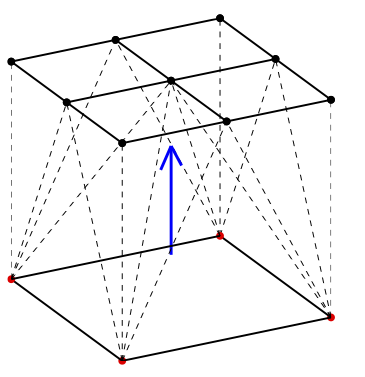

While the overall scheme will be the same for TP5 multigrid method, it's how it translates numerically that'll change.

Then we had a node-centered scheme, allowing to interpolate from node directly. For instance, if one wanted to provide node in (i,j) from coarser mesh, he could simply consider value from (i,j) as value it wouldn't change, as it's exact at nodes.

On the contrary, if one knows value for a cell, the point will be to decide on a scheme to use in order to get value at node out of value from cells.

Then, the "weights" to put in front of each node to extrapolate won't be intuitive anymore but rather arbitrary, depending on the interpolation one uses. Let's develop that a bit.

Here during TP5, we know values for a cell. Thereby, as we consider a descretized mesh here, we'll have to go from known cell value to equivalent for the nodes.

For instance, if we once again go from coarser to finer mesh. Let's say we go to a finer mesh where a cell becomes 4 cells, as for TP4.
Then, the value in (i,j) will now be obtained from 4 nodes while it was from 1 before. The point there isn't the number of nodes we extrapolate from but why we do differently. Here is again the extrapolation scheme for representation's sake :

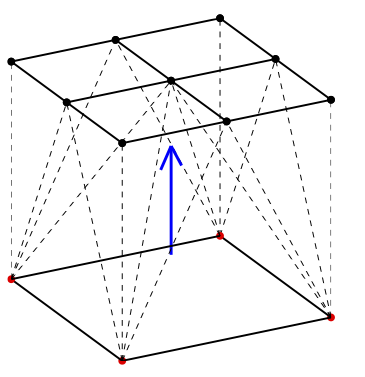

Thus, in what we do differently, if we consider weights out of 16 we may get node (i,j) from different possible combination :

- 0.5 previous node (i,j) + 0.2 times directly surrounding nodes (i,j+1) and (i+1,j) + 0.1 times last farthe node

or

- 0.4 previous node (i,j) + 0.25 times directly surrounding nodes (i,j+1) and (i+1,j) + 0.1 times last farthe node


or

- 0.7 previous node (i,j) + 0.12 times directly surrounding nodes (i,j+1) and (i+1,j) + 0.06 times last farthe node

and so on.

**The weight one considers may be considered quiet high from previous equivalent node and be lower for further away nodes.**

$\Rightarrow$ To conclude, to have considered a new meshing method simplified a part of caclulation and results, but on the other hand it complexified the methodology we get through for multigrids method.

Let's see what else changed with this TP, such as BC.

#### Q3 - BC - Neumann & Dirichlet

In this part of the report we will go through the implementation of BC.

First and foremost, we will go through the different boundary conditions we want to impose. We will then see how it translates as a simple scheme for numerical use. Finally, we will conclude on what BC may be furthermore considered.

There are in fact two BC we consider here : 

- Dirichlet BC

- Neumann BC

Then while the first one imposes a condition on the variable directly, the second one imposes the condition on the varaible's derivative.

In our case, we want to be able to impose the speed on edges when needed, and impose condition on pressure gradient.

##### Neumann - pressure gradient

For waht is up to the condition on the pressure gradient, as it's a condition on the pressure derivative, it's gonna be a Neumann BC. We in fact want to impose it as an element to sove Poisson equation. It translates the continuity on presssure field, saying the pressure at domain's exit is equal to pressure inside. It then accounts for edges across which we have continuity of pressure.

Mathematically :
    
$$P(x+\Delta x, y) = P(x, y) + \Delta x \partial_x P(x,y) + o(\Delta x^2)$$
$$\Rightarrow \partial_x P(x,y) = \frac{P(x+\Delta x, y) - P(x, y)}{\Delta x}  + o(\Delta x^2)$$

Then at first order, the first derivative of pressure (i.e. pressure gradient) is given by above relation. Then if one wants to ensure continuity : 
    
$$\partial_x P(x,y) \approx \frac{P(x+\Delta x, y) - P(x, y)}{\Delta x} = 0$$
$$\Rightarrow P(x+\Delta x, y) = P(x, y)$$

As a conclusion, the Neumann condition we imposed on pressure translates by this last equality. You may note we considered condition on x axis, but the same holds for y axis. We then apply it at considered nodes, i.e. at edges where we impose BC here (x=0/1 & y=0/1) : 

$$p[:, 0]  = p[:,  1]$$
$$p[:,-1]  = p[:, -2]$$
$$p[0, :]  = p[1,  :]$$
$$p[-1,:]  = p[-2, :]$$

$\underline{Note}$ **: BC are here applied and/or deduced from ghost cell : we provide value at mesh's limit from an extra cell considered only for BC purpose**.

You may see in **Poisson_solve.py** file that this is indeed the BC we impose, through an equality between sonsecutive nodes.

##### Dirichlet - speed

For the speed, which is the direct quantity we work with, we model our domain as a closed mesh. Therefore, the fluid in it doesn't leave, even though we have a continuity of pressure field. Therefore, instead of having a fluid at exit that's equal to the one on mesh, **we here have a reflecting boundary condition**. Thus, as we have a non-zero speed on edges, we will here have a **mean speed of zero**.

In fact, to ensure the speed bounces back, we kind of send an opposed speed, such that mean speed will be zero (as for water hitting a wall).

This physical interpretation is bounded to the mathematical expression of the mean :

$$\frac{u(x+\Delta x,y) + u(x,y)}{2} = 0$$
$$\Rightarrow u(x+\Delta x,y) = - u(x,y)$$

We can see on this last relation that we impose speed at edge from opposed of speed aside it. **Once again, we here show relation for x component on x edge but same holds for speed imposed on y edges and for v component.**

At these BC, we simply then add a **corrective term** due to splitting method. We here do nothing particular except implementing numerical derivative, and add it at edges (x = 0/1; y = 0/1).

In order to see that we understood well the BC system, we hee below impose a new one to see result on the mesh vs expectation.

#### Q4 - New BC

We've seen that to imply a condition on the speed on the edges implies to choose the location and what component is concerned (as 2D).
Here, we choose to keep previous BC, and to impose a new one on side $x = 1$ : $v(x=1,y) = 1$.
    
We thus apply an upwards vertical speed of same value than the rightwards one. Numerically, this translates as an additional term that looks as this :

v[-1, :] = -v[-2, :]  + 2*bcflag*(**1.0** + dt*py2)

We thus impose reflecting BC through $v[-1, :] = -v[-2, :]$ equality and then impose directly a speed through highlighted term, while other term is accounting for corrective term.

As a result, we expect the speed to meet in top right corner and possibly reflect elsewhere on the flow by reflection on edges.

Here below is the resulting graph giving displacement field over the mesh, accounting for new BC : 

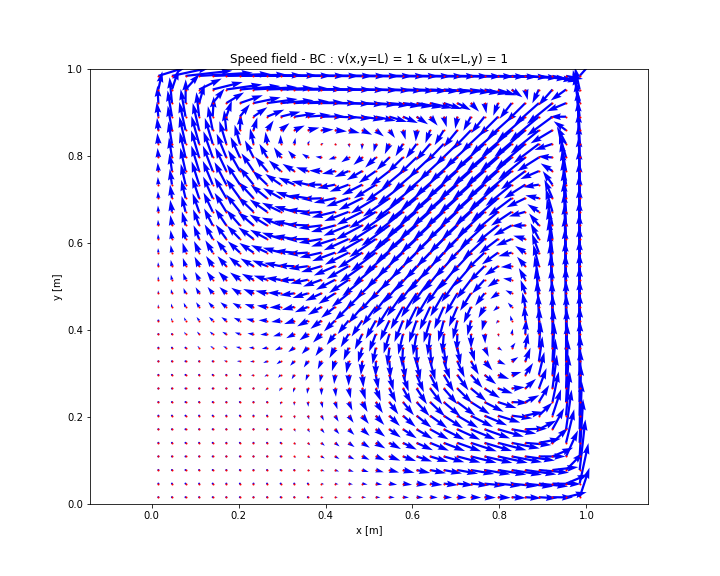

In [7]:
from IPython.display import display, Image, Math
i=Image(filename='Figures/speedField2.png', width=600)
display(i)

We can see the speed doeas go upwards on the right BC while both speed meets in top right hand side corner. What one may note have expected is that we now have two vortices like flows, splitting the mesh into 2 symmetrical sides.

Thereby, the speed that arrives in corner bounces back as expected from BC and under the influence of two imposed speeds, it goes in only possible way. Then, as for before, the fluid's motion takes other part of the fluid with it due to convection, resulting into these swirling flows.

#### $\underline{Conclusion}$

$\Rightarrow$ **As a conclusion, we have been developping through 5 practical works the necessary elements one needs to solve Navier-Stokes equation, from diffusive to convective solving through corrective terms.**

**We have then implemented several methods to balance pros and cons of each and be able to finally use one that we master and know is one if not the most efficient in the frameworks considered so far.**